In [22]:
import pandas as pd
import numpy as np


In [23]:
from validation.TensileExperimental import TensileExperimental

r = TensileExperimental()

df       = r["df"]
df_stats = r["df_stats"]

In [24]:
df_stats
# remove TFP1 
df_stats = df_stats[df_stats.index != "TFP1"]
df_stats

Modulo (GPa)           Espesor (mm)                 layers v [X,SX,Y,SY]  \
             mean       std         mean       std                              
Name                                                                            
TFP2     2.258503  0.065626     4.700000  0.000000       [Y, X]  [1, 0, 1, 0]   
TFP3     2.000437  0.004435     4.833333  0.057735      [Y, SX]  [0, 1, 1, 0]   
TFP4     2.451362  0.114353     4.700000  0.000000      [Y, SY]  [0, 0, 1, 1]   
TFP5     1.626582  0.120272     5.700000  0.000000  [Y, SX, SY]  [0, 1, 1, 1]   
TFP6     1.739870  0.067515     5.600000  0.000000   [Y, X, SY]  [1, 0, 1, 1]   

     ni  
         
Name     
TFP2  2  
TFP3  2  
TFP4  2  
TFP5  3  
TFP6  3

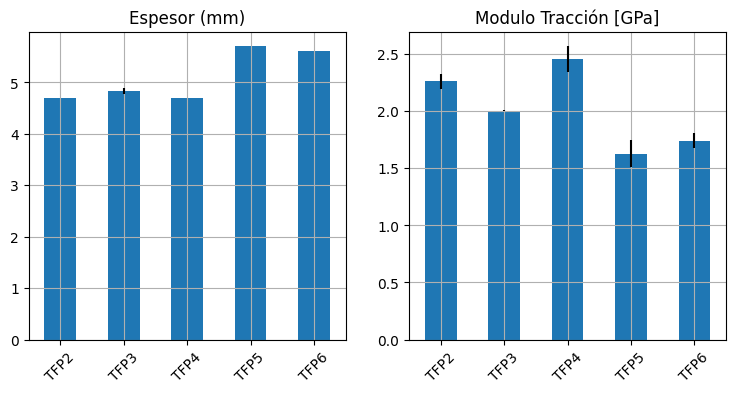

In [25]:
from validation.TensileExperimental import TensilePlotData

TensilePlotData(df_stats)

In [26]:
# only thin 

ni = df_stats["ni"].values
tau_exp = df_stats["Espesor (mm)"]["mean"].values

tau_pred_fcn = lambda tn,tl: tn + 2*tl*ni

In [27]:
# min square error

from scipy.optimize import basinhopping
def objective(tn,tl):
    return sum((tau_pred_fcn(tn,tl) - tau_exp)**2)


In [28]:
def E_effective_j(tn,tl,En,Evec,j):
    
    tau_pred = tau_pred_fcn(tn,tl)

    delta_j  = df_stats["v [X,SX,Y,SY]"].iloc[j]

    tau_j    = tau_pred[j]

    return (En*tn + tl*(np.dot(delta_j,Evec)))/tau_j

def E_effective(En,Evec,tn,tl):
    return np.array([E_effective_j(tn,tl,En,Evec,j) 
                     for j in range(len(df_stats))])


In [29]:
E_eff_exp = df_stats["Modulo (GPa)"]["mean"].values

Evec_0 = np.array([1,0,0,0])
En_0 = 100
tn_0 = 1
tl_0 = 1

E_eff_pred = E_effective(En_0,Evec_0,tn_0,tl_0)
tau_pred = tau_pred_fcn(tn_0,tl_0)

In [30]:
def theta(x):
    return 0.5*(np.sign(x)+1)

relu = lambda x: x*theta(x)

In [31]:
from validation.experimental import  nucleo

E_nucleo_exp_Mpa = nucleo()["young modulus [MPa]"]
E_nucleo_exp = E_nucleo_exp_Mpa/1000
print(E_nucleo_exp)

from validation.experimental import manual_data

t_nucleo_exp = manual_data()["t_nucleo [mm]"]

0.8


In [32]:
# minimize 
def objective_E(En,Evec,tn,tl):
    Loss_E   = sum((E_effective(En,Evec,tn,tl) - E_eff_exp)**2)
    Loss_tau = sum((tau_pred_fcn(tn,tl) - tau_exp)**2)
    
    # En < Evec[0]
    Emax = np.max(Evec)
    lag_mult = 0*1e6*relu( En - Emax) # Asumimos que el nucleo es el material más blando que la capas E[0] -> X
    
    return Loss_E + Loss_tau + lag_mult
           

x0 = np.random.rand(7)
# must be positive 

bounds = [  (E_nucleo_exp*0.9,1.1*E_nucleo_exp), # En
            (0.0,None), # Evec[0]   # X
            (0.0,None), # Evec[1]   # Y
            (0.0,None), # Evec[2]   # SX
            (0.0,None), # Evec[3]   # SY
            (0.9*t_nucleo_exp,1.1*t_nucleo_exp), # tn
            (0.25,2)  # tl
            ]
          
# set constraints
if x0[1] < x0[0]:
    x0[1] = x0[0]

for k,ib in enumerate(bounds):

    if ib[0] is not None and x0[k] < ib[0]:
        x0[k] = ib[0]
    if ib[1] is not None and x0[k] > ib[1]:
        x0[k] = ib[1]


In [33]:

minimize_kwargs = {
    'method': 'trust-constr',
    'bounds': bounds
}

res = basinhopping(lambda x: objective_E(x[0],x[1:5],x[5],x[6]),
                x0, 
                minimizer_kwargs= minimize_kwargs,
                niter=10,
                stepsize=0.5)

En_opt   = res.x[0]
Evec_opt = res.x[1:5]
tn_opt   = res.x[5]
tl_opt   = res.x[6]


E_eff_pred = E_effective(En_opt,Evec_opt,tn_opt,tl_opt)
tau_pred   = tau_pred_fcn(tn_opt,tl_opt)

c:\Users\djoroya\Documents\GitHub\CITISENS_Composite\.conda\Lib\site-packages\scipy\optimize\_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


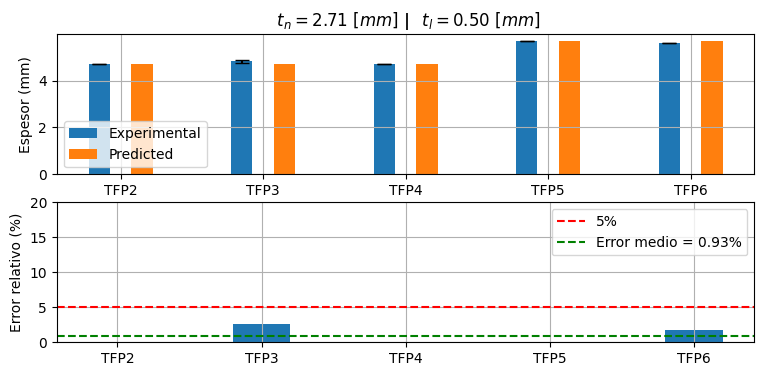

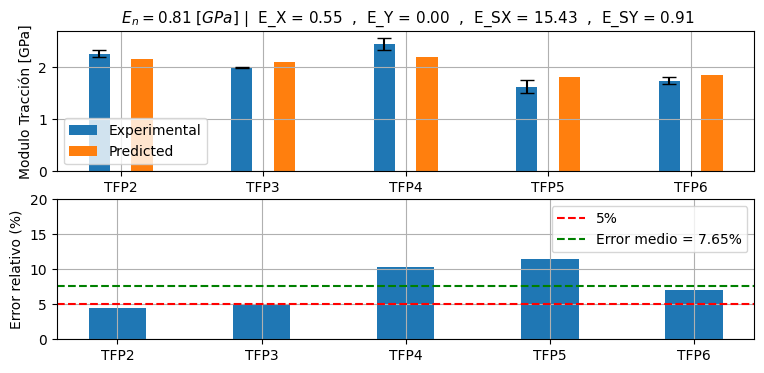

In [34]:
from AnalyticalLayers.plot_E import plot_E
from AnalyticalLayers.plt_thin import plt_thin

plt_thin(df_stats, tau_exp, tau_pred, tn_opt, tl_opt)
plot_E(df_stats, E_eff_exp, E_eff_pred, Evec_opt, En_opt)

In [35]:
df_layers = pd.DataFrame({"Evec [GPa]": Evec_opt}, index=["X","SX","Y","SY"])
# add nuclueo
df_layers.loc["Nucleo"] = [En_opt]
df_layers.round(2)

,Evec [GPa]
X,0.55
SX,0.00
Y,15.43
SY,0.91
Nucleo,0.81


In [36]:
df_thickness = pd.DataFrame({"t [mm]": [tn_opt, tl_opt]}, index=["Nucleo","Capas"])

df_thickness.round(2)

,t [mm]
Nucleo,2.71
Capas,0.50


In [37]:
print("Optimal En: ", En_opt)
print("Optimal tn: ", tn_opt)
print("Optimal tl: ", tl_opt)

Optimal En:  0.8114509496112201
Optimal tn:  2.7142605105105226
Optimal tl:  0.4975448911565201


In [38]:
df_pred = {
    "Name"          : df_stats.index,
    "E pred [GPa]"  : E_eff_pred,
    "E exp [GPa]"   : E_eff_exp,
    "E e rel [%]"   : 100*abs(E_eff_exp - E_eff_pred)/E_eff_exp,
    "t pred [mm]"   : tau_pred,
    "t exp [mm]"    : tau_exp,
    "t e rel [%]"   : 100*abs(tau_exp - tau_pred)/tau_exp
}
df_pred = pd.DataFrame(df_pred)
# decimals
df_pred = df_pred.round(2)
df_pred.head()

,Name,E pred [GPa],E exp [GPa],E e rel [%],t pred [mm],t exp [mm],t e rel [%]
0,TFP2,2.16,2.26,4.43,4.7,4.70,0.09
1,TFP3,2.10,2.00,5.00,4.7,4.83,2.67
2,TFP4,2.20,2.45,10.38,4.7,4.70,0.09
3,TFP5,1.81,1.63,11.49,5.7,5.70,0.01
4,TFP6,1.86,1.74,6.97,5.7,5.60,1.78


In [39]:
df_stats

Modulo (GPa)           Espesor (mm)                 layers v [X,SX,Y,SY]  \
             mean       std         mean       std                              
Name                                                                            
TFP2     2.258503  0.065626     4.700000  0.000000       [Y, X]  [1, 0, 1, 0]   
TFP3     2.000437  0.004435     4.833333  0.057735      [Y, SX]  [0, 1, 1, 0]   
TFP4     2.451362  0.114353     4.700000  0.000000      [Y, SY]  [0, 0, 1, 1]   
TFP5     1.626582  0.120272     5.700000  0.000000  [Y, SX, SY]  [0, 1, 1, 1]   
TFP6     1.739870  0.067515     5.600000  0.000000   [Y, X, SY]  [1, 0, 1, 1]   

     ni  
         
Name     
TFP2  2  
TFP3  2  
TFP4  2  
TFP5  3  
TFP6  3

In [40]:
Em_error = np.mean(df_pred["E e rel [%]"])
tm_error = np.mean(df_pred["t e rel [%]"])

from loadsavejson.savejson import savejson

savejson({"layers":df_layers, 
            "errors": {"E":Em_error, "t":tm_error},
          "thickness":df_thickness},
          "df_opt_free_thin.json")

In [45]:
df_thickness.round(4)

,t [mm]
Nucleo,2.7143
Capas,0.4975


In [44]:
df_layers.round(4)

,Evec [GPa]
X,0.5468
SX,0.0000
Y,15.4347
SY,0.9120
Nucleo,0.8115
